In [1]:
import os
import sys

org_wd = os.getcwd()
os.chdir('/home/smf19/creditfraud/creditfraud')
!{sys.executable} -m pip install -r /home/smf19/creditfraud/creditfraud/requirements.txt

os.chdir(org_wd)

Obtaining file:///home/smf19/creditfraud/creditfraud (from -r /home/smf19/creditfraud/creditfraud/requirements.txt (line 18))
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for frauddetection (pyproject.toml) ... done
  Created wheel for frauddetection: filename=frauddetection-0.0.1-py3-none-any.whl size=4236 sha256=7f9dd1fb122ff8465d8c297eba3da0674d77f52a3370d5b2e8b3eef7d1433f19
  Stored in directory: /tmp/pip-ephem-wheel-cache-9m6ajqot/wheels/73/b2/87/825a2bfc2a3bbab3936ad427b4246476bd25e4406874e4b444
Successfully built frauddetection
  Attempting uninstall: frauddetection
    Found existing installation: frauddetection 0.0.1
    Uninstalling frauddetection-0.0.1:
      Successfully uninstalled frauddetection-0.0.1

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip insta

In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def smote(T, N, k):
    """_summary_

    Args:
        T (ndarray): Feature matrix for minority class
        N (int): Percentage over-sampling
        k (int): Number of nearest neighbors
    """
    
    n_minority_samples, numattrs = T.shape
    
    if N < 100:
        np.random.shuffle(T)
        n_minority_samples = (N // 100) * n_minority_samples
        N = 100
        
    N = N // 100 # SMOTE is assumed to be in integral multiples of 100
    
    Synthetic = np.zeros((N * n_minority_samples, numattrs))
    newindex = 0
    
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(T)
    
    for i in range(n_minority_samples):
        nnarray = knn.kneighbors(T[i].reshape(1, -1), return_distance=False)[0]
        
        for _ in range(N):
            nn = np.random.randint(1,k)
            for x in range(numattrs):
                dif = T[nnarray[nn]][x] - T[i][x] # difference between xth attribute value of randomly chosen nearest neighbor and the xth attribute value of current sample
                # random float between 0 and 1 using uniform distribution
                gap = np.random.rand() # controls how far along the line segment between the current sample and neighbor the synthetic sample will be
                Synthetic[newindex][x] = T[i][x] + gap * dif
            newindex += 1
    
    return Synthetic


In [12]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features = 20, n_classes = 2, weights=[0.9,0.1])
minority_label = 1
T = X[y == minority_label]

k = 5

Synthetic = smote(T, N=200, k=k)

X_resampled = np.vstack((X, Synthetic))
y_resampled = np.hstack((y, np.full(Synthetic.shape[0], minority_label)))

print(f'Original dataset shape: {X.shape}, {y.shape}')
print(f'Resampled dataset shape: {X_resampled.shape}, {y_resampled.shape}')

Original dataset shape: (1000, 20), (1000,)
Resampled dataset shape: (1206, 20), (1206,)


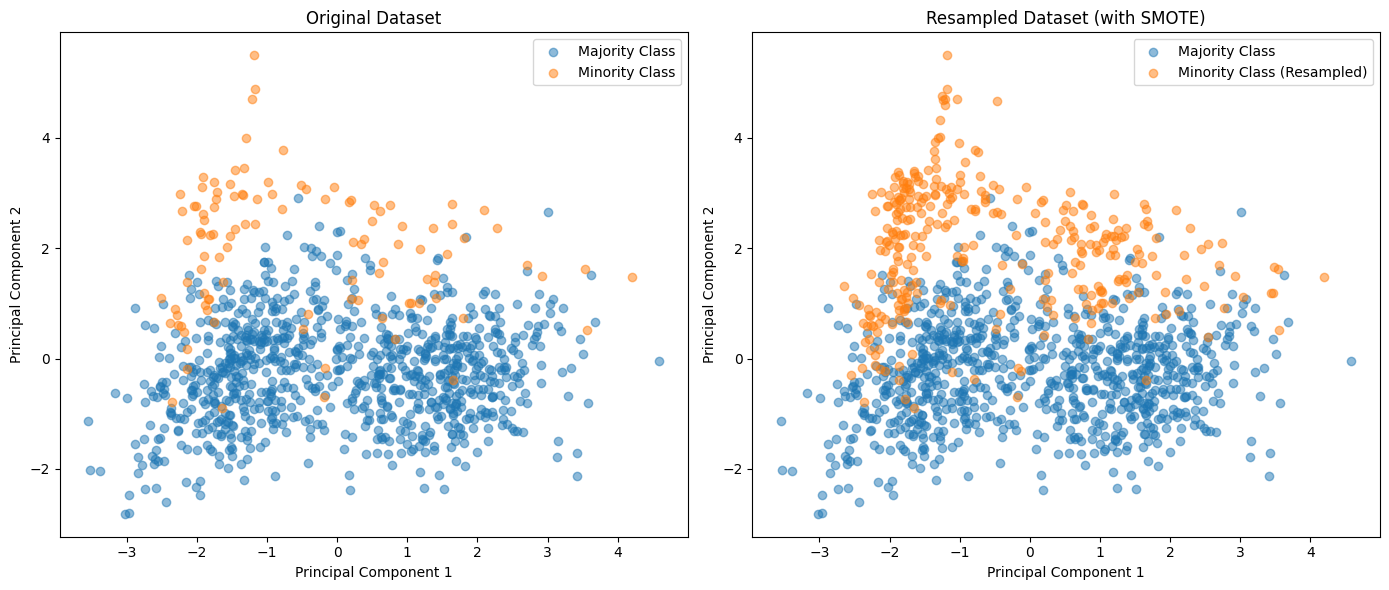

In [14]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def smote(T, N, k):
    n_minority_samples, numattrs = T.shape
    
    # If N is less than 100, randomize the minority class samples
    if N < 100:
        np.random.shuffle(T)
        n_minority_samples = (N // 100) * n_minority_samples  # Adjust the number of samples
        N = 100  # Normalize N to 100 for easier subsequent calculations
        
    N = N // 100  # Convert N to an integer factor
    Synthetic = np.zeros((N * n_minority_samples, numattrs))
    newindex = 0
    
    # Fit k-nearest neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(T)
    
    # Generate synthetic samples
    for i in range(n_minority_samples):
        # Compute k-nearest neighbors for the i-th minority sample
        nnarray = knn.kneighbors(T[i].reshape(1, -1), return_distance=False)[0]
        
        for _ in range(N):
            # Choose a random neighbor index from the k nearest neighbors
            nn = np.random.randint(1, k)  # Choose a random neighbor index (1 to k-1)
            
            for attr in range(numattrs):
                # Calculate the difference between the neighbor's and the current sample's attribute value
                dif = T[nnarray[nn]][attr] - T[i][attr]
                gap = np.random.rand()  # Generate a random gap value between 0 and 1
                # Create a synthetic sample by interpolating between the current sample and the neighbor
                Synthetic[newindex][attr] = T[i][attr] + gap * dif
            newindex += 1
    
    return Synthetic

# Create a sample dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.9, 0.1])

# Extract minority class samples
minority_class_label = 1
T = X[y == minority_class_label]

# Define k (number of nearest neighbors)
k = 5

# Apply SMOTE
Synthetic = smote(T, N=200, k=k)

# Combine original and synthetic samples
X_resampled = np.vstack((X, Synthetic))
y_resampled = np.hstack((y, np.full(Synthetic.shape[0], minority_class_label)))

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Plot original dataset
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], label='Majority Class', alpha=0.5)
plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], label='Minority Class', alpha=0.5)
plt.title('Original Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Plot resampled dataset
plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[y_resampled == 0][:, 0], X_resampled_pca[y_resampled == 0][:, 1], label='Majority Class', alpha=0.5)
plt.scatter(X_resampled_pca[y_resampled == 1][:, 0], X_resampled_pca[y_resampled == 1][:, 1], label='Minority Class (Resampled)', alpha=0.5)
plt.title('Resampled Dataset (with SMOTE)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()


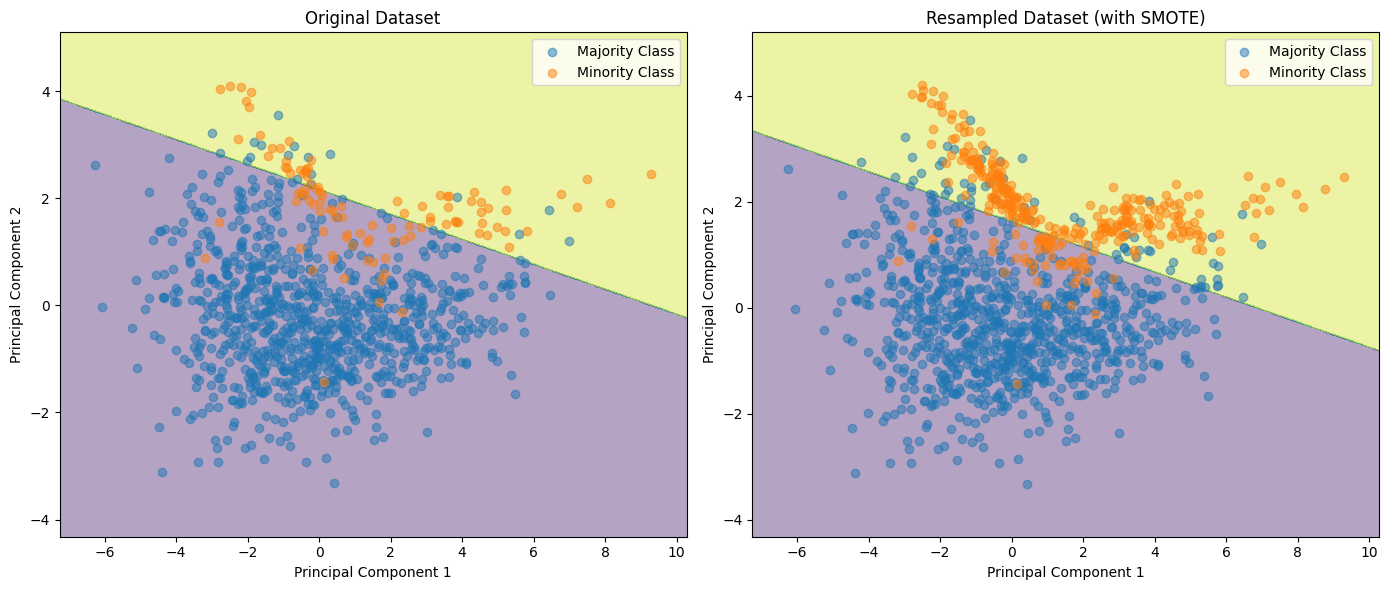

In [15]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def smote(T, N, k):
    n_minority_samples, numattrs = T.shape
    
    # If N is less than 100, randomize the minority class samples
    if N < 100:
        np.random.shuffle(T)
        n_minority_samples = (N // 100) * n_minority_samples  # Adjust the number of samples
        N = 100  # Normalize N to 100 for easier subsequent calculations
        
    N = N // 100  # Convert N to an integer factor
    Synthetic = np.zeros((N * n_minority_samples, numattrs))
    newindex = 0
    
    # Fit k-nearest neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(T)
    
    # Generate synthetic samples
    for i in range(n_minority_samples):
        # Compute k-nearest neighbors for the i-th minority sample
        nnarray = knn.kneighbors(T[i].reshape(1, -1), return_distance=False)[0]
        
        for _ in range(N):
            # Choose a random neighbor index from the k nearest neighbors
            nn = np.random.randint(1, k)  # Choose a random neighbor index (1 to k-1)
            
            for attr in range(numattrs):
                # Calculate the difference between the neighbor's and the current sample's attribute value
                dif = T[nnarray[nn]][attr] - T[i][attr]
                gap = np.random.rand()  # Generate a random gap value between 0 and 1
                # Create a synthetic sample by interpolating between the current sample and the neighbor
                Synthetic[newindex][attr] = T[i][attr] + gap * dif
            newindex += 1
    
    return Synthetic

# Create a sample dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.9, 0.1])

# Extract minority class samples
minority_class_label = 1
T = X[y == minority_class_label]

# Define k (number of nearest neighbors)
k = 5

# Apply SMOTE
Synthetic = smote(T, N=200, k=k)

# Combine original and synthetic samples
X_resampled = np.vstack((X, Synthetic)) # shape of X should be (1000 + n_synthetic, 20)
y_resampled = np.hstack((y, np.full(Synthetic.shape[0], minority_class_label)))

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Train logistic regression on original dataset
clf_original = LogisticRegression()
clf_original.fit(X_pca, y)

# Train logistic regression on resampled dataset
clf_resampled = LogisticRegression()
clf_resampled.fit(X_resampled_pca, y_resampled)

# Plot decision boundaries
def plot_decision_boundary(clf, X, y, title, subplot):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(1, 2, subplot)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Majority Class', alpha=0.5)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Minority Class', alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

# Plot original dataset with decision boundary
plt.figure(figsize=(14, 6))

plot_decision_boundary(clf_original, X_pca, y, 'Original Dataset', 1)

# Plot resampled dataset with decision boundary
plot_decision_boundary(clf_resampled, X_resampled_pca, y_resampled, 'Resampled Dataset (with SMOTE)', 2)

plt.tight_layout()
plt.show()
